# House Prices: Advanced Regression Techniques

### Iason Tsardanidis (1846834)

In this project I will try to predict the Houses SalePrice from a given dataset of **Kaggle** using various regression techniques and a simple implementation of *tensorflow* package

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/logos/front_page.png)

In [1]:
#importing libraries I will need
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, RidgeCV,LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import itertools
import xgboost as xgb
import tensorflow as tf

In [2]:
#importing train and test datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
s = train.shape[0]
y_train = np.log1p(train["SalePrice"])

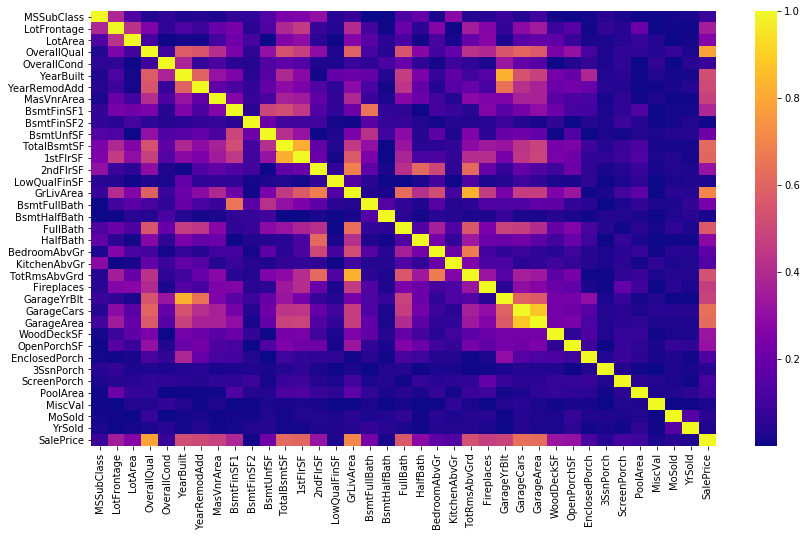

In [3]:
#heatmap plot
plt.figure(figsize=(14,8))
sns.heatmap(abs(train.corr()), cmap='plasma')

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


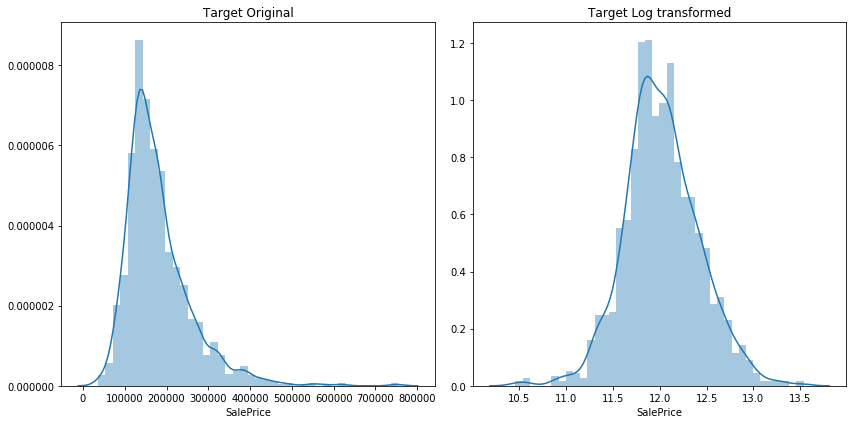

In [4]:
#target log-transormation
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(train.SalePrice, bins=40)
plt.title('Target Original')

plt.subplot(1,2,2)
sns.distplot(y_train, bins=40)
plt.title('Target Log transformed')

plt.tight_layout()



In [5]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.index = np.arange(1, len(all_data) + 1)

In [6]:
all_data.head(10)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
6,796,566,320,NaN,1,1Fam,TA,No,732.0,0.0,...,WD,0,Pave,5,796.0,AllPub,40,1993,1995,2009
7,1694,0,0,NaN,3,1Fam,TA,Av,1369.0,0.0,...,WD,0,Pave,7,1686.0,AllPub,255,2004,2005,2007
8,1107,983,0,NaN,3,1Fam,TA,Mn,859.0,32.0,...,WD,0,Pave,7,1107.0,AllPub,235,1973,1973,2009
9,1022,752,0,NaN,2,1Fam,TA,No,0.0,0.0,...,WD,0,Pave,8,952.0,AllPub,90,1931,1950,2008
10,1077,0,0,NaN,2,2fmCon,TA,No,851.0,0.0,...,WD,0,Pave,5,991.0,AllPub,0,1939,1950,2008


## Missing_Values

In [7]:
percent = (all_data.isnull().sum()/len(all_data)).sort_values(ascending=False)
percent.head(10)

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageFinish    0.054471
GarageQual      0.054471
GarageYrBlt     0.054471
GarageCond      0.054471
dtype: float64

In [8]:
#categorical data: replacing NA with none
columns_1 = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
           'MasVnrType','MSSubClass','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
#numerical data: replacing NA with 0
columns_2 = ['GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 
             'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea']
#categorical data: replacing NA with most frequent value
columns_3 = ['MSZoning','Electrical','Utilities','KitchenQual','Functional','Exterior1st','Exterior2nd','SaleType']

for col in columns_1:
    all_data[col] = all_data[col].fillna('None')
    
for col in columns_2:
    all_data[col] = all_data[col].fillna(0)
    
for col in columns_3:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
#fill NA value with the median   
all_data["LotFrontage"] = all_data['LotFrontage'].fillna(all_data['LotFrontage'].median())

In [9]:
# all_data.drop('Condition2',1,inplace=True)
# all_data.drop('Utilities',1,inplace=True)

In [10]:
missing_values = []
for c in all_data.columns:
    missing_values.append(all_data[c].isnull().sum())
    if missing_values[-1] > 0:
        print(c,missing_values[-1])
if sum(missing_values) == 0:
    print('No Missing Values')

No Missing Values


In [11]:
categorical_columns = [col for col in all_data.columns.values if all_data[col].dtype == 'object']
numerical_columns = [col for col in all_data.columns.values if all_data[col].dtype != 'object']

data_num = all_data[numerical_columns]

## Skewed data: using transformations

In [12]:
data_skewed = all_data[numerical_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
data_skewed = data_skewed[abs(data_skewed) > .75]

In [13]:
data_skewed

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.674852
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
GarageYrBlt      -3.906205
dtype: float64

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm

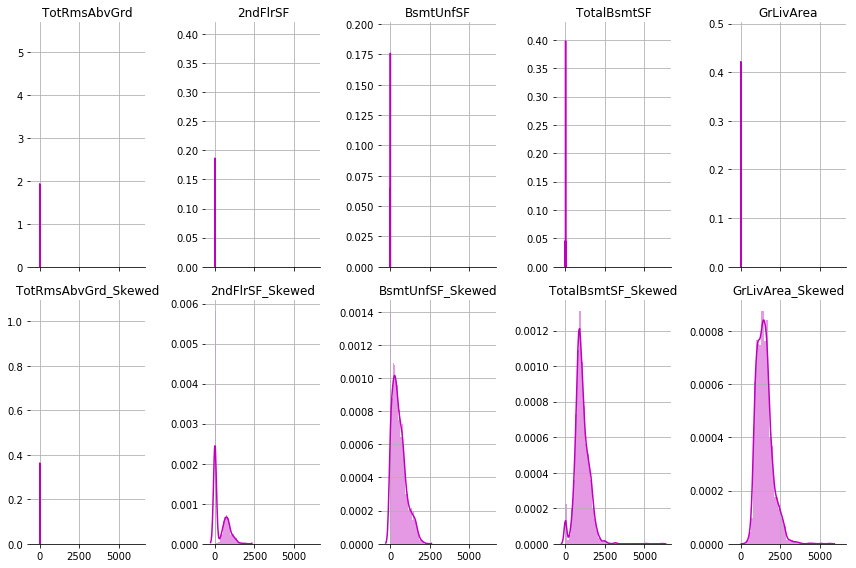

In [14]:
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,8), sharex=True)
sns.despine(left=True)
# Generate a random univariate dataset
for i in range(2):
    for j in range(5):
        ind = - (2+j)
        title = data_skewed.index[ind] 
        if i == 1:
            title = title + '_Skewed'
            sns.distplot(all_data[data_skewed.index[ind]], color="m", ax=axes[i, j],axlabel='')
        else:
            sns.distplot(boxcox1p(all_data[data_skewed.index[ind]],0.15), color="m", ax=axes[i, j],axlabel='')
        axes[i,j].set_title(title)  
        axes[i,j].grid(True)       
plt.tight_layout()

In [15]:
col = list(data_skewed.index)
# data_skewed_1 = data_skewed[data_skewed > .75]
# data_skewed_2 = data_skewed[data_skewed < -0.75]
# col_1 = list(data_skewed_1.index)
# col_2 = list(data_skewed_2.index)
# all_data[col_1] = np.log1p(all_data[col_1])    #for positively skewed
# all_data[col_2] = np.square(all_data[col_2])   #for negatively skewed
all_data[col] = boxcox1p(all_data[col], 0.15)

* I decided to use boxcox transformation instead of logirithmic or other kind in order to smoothen the skewed data since it gives me better results

## Drop outliers

In [16]:
Q1 = data_num.quantile(0.25)
Q3 = data_num.quantile(0.75)
IQR = Q3 - Q1


a = data_num[(data_num < (Q1 - 1.5 * IQR)) |(data_num > (Q3 + 1.5* IQR))]
b = a[a.count()[a.count() < 20].index].sum(1)
outliers = b[b>0].index
outliers = [x for x in outliers if x < s ]
#all_data.drop(outliers,inplace = True)
#y_train.drop(outliers,inplace = True)
#s -= len(outliers)
#c = ['EnclosedPorch','ScreenPorch','WoodDeckSF']

* after careful implementing of outliers removal I decide not to remove them since the final performance becoming worse

In [17]:
#Label encoding of some features replacing values with numbers
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
       'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
       'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
       'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
       'YrSold', 'MoSold')
for col in columns:
    label = LabelEncoder() 
    label.fit(list(all_data[col].values)) 
    all_data[col] = label.transform(list(all_data[col].values))

## Some data engineering

In [18]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data["TotBsmtFin"] = all_data["BsmtFinSF1"] + all_data["BsmtFinSF2"]
all_data["TotBath"] = all_data["FullBath"] + 0.5*all_data["HalfBath"] + all_data["BsmtFullBath"] + 0.5*all_data["BsmtHalfBath"]

In [19]:
all_data.shape

(2919, 82)

## Dummies creation

In [20]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2919, 225)

## Train and Test data split

In [21]:
train = all_data[:s]
test = all_data[s:]

## Most important features selection using LASSO

Lasso picked 101 variables and eliminated the other 124 variables


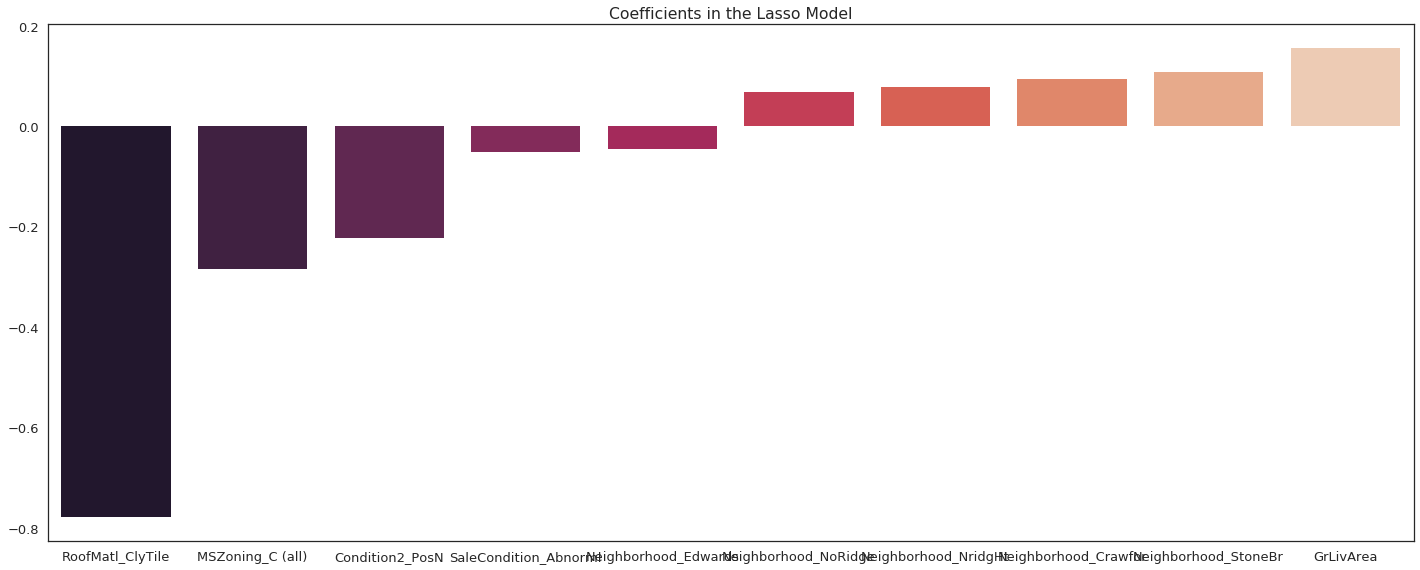

In [22]:
#Finding the most important features
model_lasso = LassoCV(alphas = [5,2,1, 0.1,0.005, 0.001,0.0005]).fit(train, y_train)
coef = pd.Series(model_lasso.coef_, index = train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


coef = pd.concat([coef.sort_values().head(5),coef.sort_values().tail(5)])

plt.figure(figsize=(20,8))
sns.set(style="white", context="talk")
sns.barplot(coef.index,coef.values,palette="rocket")
plt.tight_layout()
plt.title("Coefficients in the Lasso Model")  
plt.show()  

In [23]:
#Keeping only the features that have coeff. different than zero!!!
top = np.array(abs(model_lasso.coef_)).argsort()[::-1][:101]
top = np.sort(top)
train = train.iloc[:,top]
test = test.iloc[:,top]

### 5-folds cross validation

In [24]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Ridge Model

In [25]:
model_ridge = Ridge()
alphas = [0.01,0.003,0.05, 0.1, 0.3, 0.5, 1, 1.5, 2, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = np.array([rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas])
print("The min value of Ridge is ",cv_ridge.min())
best_alpha = alphas[cv_ridge.argmin()]
model_ridge = Ridge(alpha = best_alpha).fit(train, y_train)

The min value of Ridge is  0.1204343393094103


### LASSO Model

In [26]:
model_lasso = LassoCV(alphas = [5,2,1, 0.1,0.005, 0.001,0.0005]).fit(train, y_train)
print("The min value of Lasso is ",rmse_cv(model_lasso).mean())

The min value of Lasso is  0.12261214660994864


### Extreme Gradient Boosting Model

In [27]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.03,  
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=3, n_estimators=3000, 
                             reg_alpha=0.2, reg_lambda=0.7,
                             subsample=0.5, silent=1,
                             random_state=4, nthread = -1).fit(train, y_train)  

print("The min value of XGB is ",rmse_cv(model_xgb).mean())

The min value of XGB is  0.11905123097056905


### Gradient Boosting Model

In [28]:
model_GBoost = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber',random_state=7).fit(train,y_train)  

print("The min value of GBoost is ",rmse_cv(model_GBoost).mean())

The min value of GBoost is  0.12310575712915636


### Light Gradient Boosting Model

In [29]:
model_LGB = lgb.LGBMRegressor(objective='regression',
                              num_leaves=30, max_depth=4, learning_rate=0.01, 
                              n_estimators=2500, max_bin=250, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 12).fit(train,y_train)

print("The min value of LGB is ",rmse_cv(model_LGB).mean())

The min value of LGB is  0.12123059035110458


In [30]:
#Models Predictions
lasso_preds = np.expm1(model_lasso.predict(test))
ridge_preds = np.expm1(model_ridge.predict(test))
xgb_preds = np.expm1(model_xgb.predict(test))
GBoost_preds = np.expm1(model_GBoost.predict(test))
LGB_preds = np.expm1(model_LGB.predict(test))

### Tensorflow Shallow Multilayer Perceptron

In [31]:
#Data Normalization between [0,1]
all_data = all_data.iloc[:,top]
scaler = MinMaxScaler()
scaler.fit(all_data)

train = pd.DataFrame(scaler.transform(train),columns = train.columns)
test  = pd.DataFrame(scaler.transform(test),columns = test.columns)

train['SalePrice'] = y_train

train.head()

,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,RoofMatl_ClyTile,RoofMatl_WdShngl,RoofStyle_Gable,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleType_COD,SaleType_New,SaleType_WD,SalePrice
0,0.818185,0.0,0.5,0.375,1.00,0.75,0.631368,0.0,0.333333,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.247699
1,0.000000,0.0,0.5,0.375,1.00,0.25,0.681814,0.0,0.000000,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.109016
2,0.820875,0.0,0.5,0.375,1.00,0.50,0.576542,0.0,0.333333,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.317171
3,0.794934,0.0,0.5,0.375,0.25,0.75,0.467677,0.0,0.000000,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,11.849405
4,0.859155,0.0,0.5,0.500,1.00,0.00,0.620109,0.0,0.333333,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.429220


In [32]:
train.rename({'Exterior1st_Wd Sdng':'Exterior1st_Wd_Sdng'}, axis='columns',inplace=True)
train.rename({'Exterior2nd_Brk Cmn':'Exterior2nd_Brk_Cmn'}, axis='columns',inplace=True)
train.rename({'Exterior2nd_Wd Sdng':'Exterior2nd_Wd_Sdng'}, axis='columns',inplace=True)
train.rename({'Exterior2nd_Wd Shng':'Exterior2nd_Wd_Shng'}, axis='columns',inplace=True)
train.rename({'MSZoning_C (all)':'MSZoning_C_all'}, axis='columns',inplace=True)
train.rename({'HouseStyle_1.5Fin':'HouseStyle_1_5Fin'}, axis='columns',inplace=True)
train.rename({'HouseStyle_1.5Unf':'HouseStyle_1_5Unf'}, axis='columns',inplace=True)
train.rename({'HouseStyle_2.5Fin':'HouseStyle_2_5Fin'}, axis='columns',inplace=True)
train.rename({'HouseStyle_2.5Unf':'HouseStyle_2_5Unf'}, axis='columns',inplace=True)
train.rename({'RoofMatl_Tar&Grv':'RoofMatl_Tar_Grv'}, axis='columns',inplace=True)

In [33]:
columns = list(train.columns).copy()
features = columns[:-1]

feature_cols = [tf.contrib.layers.real_valued_column(k) for k in features]

training_set = train[columns]
prediction_set = train.SalePrice

# Split Train and Test samples from the training_data
x_train, x_test, y_train, y_test = train_test_split(training_set[features] , prediction_set, test_size=0.3, random_state=101)
y_train = pd.DataFrame(y_train, columns = ["SalePrice"])
training_set = pd.DataFrame(x_train, columns = features).merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test, columns = ["SalePrice"])
testing_set = pd.DataFrame(x_test, columns = features).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,RoofMatl_ClyTile,RoofMatl_WdShngl,RoofStyle_Gable,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleType_COD,SaleType_New,SaleType_WD,SalePrice
1054,0.827894,0.0,0.5,0.375,1.0,0.50,0.674199,0.000000,0.333333,1.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.449023
361,0.725139,0.0,1.0,0.375,1.0,0.75,0.548811,0.000000,0.833333,1.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,11.884496
1282,0.000000,0.0,0.5,0.375,1.0,0.50,0.589537,0.553942,0.500000,0.833333,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,11.921725
161,0.867132,0.0,0.5,0.375,1.0,0.00,0.687878,0.000000,0.333333,1.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.929994
515,0.000000,0.0,0.5,0.375,1.0,0.75,0.744544,0.000000,0.333333,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.906349


In [34]:
# Model decision
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[50],
                                         optimizer = tf.train.ProximalAdagradOptimizer(learning_rate=0.1,l2_regularization_strength=0.0005),
                                         dropout=False)

Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3939e11860>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_mode

In [35]:
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

In [36]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in features}
        labels = tf.constant(data_set['SalePrice'].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in features}
        
        return feature_cols

In [37]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=120000)

Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9ky65ze7/model.ckpt.
INFO:tensorflow:loss = 138.06233, step = 1
INFO:tensorflow:global_step/sec: 502.133
INFO:tensorflow:loss = 0.3186185, step = 101 (0.200 sec)
INFO:tensorflow:global_step/sec: 682.972
INFO:tensorflow:loss = 0.24695663, step = 201 (0.147 sec)
INFO:tensorflow:global_step/sec: 636.383
INFO:tensorflow:loss = 0.2633758, step = 301 (0.157 sec)
INFO:tensorflow:global_step/sec: 654.894
INFO:tensorflow:loss = 0.20385855, step = 401 (0.153 sec)
INFO:tensorflow:global_step/sec: 662.026
INFO:tensorflow:loss = 0.15347233, step = 501 (0.151 s

INFO:tensorflow:loss = 0.033893418, step = 2901 (0.149 sec)
INFO:tensorflow:global_step/sec: 644.818
INFO:tensorflow:loss = 0.03212351, step = 3001 (0.155 sec)
INFO:tensorflow:global_step/sec: 589.69
INFO:tensorflow:loss = 0.03175641, step = 3101 (0.170 sec)
INFO:tensorflow:global_step/sec: 663.771
INFO:tensorflow:loss = 0.030240616, step = 3201 (0.150 sec)
INFO:tensorflow:global_step/sec: 668.915
INFO:tensorflow:loss = 0.029481601, step = 3301 (0.150 sec)
INFO:tensorflow:global_step/sec: 602.377
INFO:tensorflow:loss = 0.02838949, step = 3401 (0.166 sec)
INFO:tensorflow:global_step/sec: 613.299
INFO:tensorflow:loss = 0.027396245, step = 3501 (0.163 sec)
INFO:tensorflow:global_step/sec: 658.238
INFO:tensorflow:loss = 0.026732294, step = 3601 (0.152 sec)
INFO:tensorflow:global_step/sec: 615.893
INFO:tensorflow:loss = 0.027020292, step = 3701 (0.162 sec)
INFO:tensorflow:global_step/sec: 629.146
INFO:tensorflow:loss = 0.025654761, step = 3801 (0.160 sec)
INFO:tensorflow:global_step/sec: 66

INFO:tensorflow:global_step/sec: 645.582
INFO:tensorflow:loss = 0.013071174, step = 11101 (0.153 sec)
INFO:tensorflow:global_step/sec: 630.91
INFO:tensorflow:loss = 0.013205923, step = 11201 (0.163 sec)
INFO:tensorflow:global_step/sec: 483.642
INFO:tensorflow:loss = 0.013404577, step = 11301 (0.202 sec)
INFO:tensorflow:global_step/sec: 675.119
INFO:tensorflow:loss = 0.012832676, step = 11401 (0.148 sec)
INFO:tensorflow:global_step/sec: 635.59
INFO:tensorflow:loss = 0.013090428, step = 11501 (0.158 sec)
INFO:tensorflow:global_step/sec: 705.31
INFO:tensorflow:loss = 0.012478155, step = 11601 (0.142 sec)
INFO:tensorflow:global_step/sec: 693.045
INFO:tensorflow:loss = 0.012456568, step = 11701 (0.144 sec)
INFO:tensorflow:global_step/sec: 619.016
INFO:tensorflow:loss = 0.012350216, step = 11801 (0.162 sec)
INFO:tensorflow:global_step/sec: 617.002
INFO:tensorflow:loss = 0.012293949, step = 11901 (0.162 sec)
INFO:tensorflow:global_step/sec: 550.192
INFO:tensorflow:loss = 0.012418979, step = 1

INFO:tensorflow:loss = 0.007592595, step = 19101 (0.179 sec)
INFO:tensorflow:global_step/sec: 619.547
INFO:tensorflow:loss = 0.008774453, step = 19201 (0.161 sec)
INFO:tensorflow:global_step/sec: 646.962
INFO:tensorflow:loss = 0.007641147, step = 19301 (0.155 sec)
INFO:tensorflow:global_step/sec: 578.743
INFO:tensorflow:loss = 0.008361229, step = 19401 (0.173 sec)
INFO:tensorflow:global_step/sec: 592.6
INFO:tensorflow:loss = 0.008488275, step = 19501 (0.168 sec)
INFO:tensorflow:global_step/sec: 664.611
INFO:tensorflow:loss = 0.007562501, step = 19601 (0.151 sec)
INFO:tensorflow:global_step/sec: 641.074
INFO:tensorflow:loss = 0.008657849, step = 19701 (0.157 sec)
INFO:tensorflow:global_step/sec: 594.104
INFO:tensorflow:loss = 0.007687243, step = 19801 (0.169 sec)
INFO:tensorflow:global_step/sec: 625.031
INFO:tensorflow:loss = 0.007938941, step = 19901 (0.158 sec)
INFO:tensorflow:global_step/sec: 610.199
INFO:tensorflow:loss = 0.008455408, step = 20001 (0.164 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 682.706
INFO:tensorflow:loss = 0.0077085136, step = 27201 (0.147 sec)
INFO:tensorflow:global_step/sec: 617.45
INFO:tensorflow:loss = 0.006396778, step = 27301 (0.162 sec)
INFO:tensorflow:global_step/sec: 612.373
INFO:tensorflow:loss = 0.0067113494, step = 27401 (0.163 sec)
INFO:tensorflow:global_step/sec: 617.361
INFO:tensorflow:loss = 0.0072799786, step = 27501 (0.162 sec)
INFO:tensorflow:global_step/sec: 644.297
INFO:tensorflow:loss = 0.0060677957, step = 27601 (0.155 sec)
INFO:tensorflow:global_step/sec: 622.665
INFO:tensorflow:loss = 0.0076987017, step = 27701 (0.160 sec)
INFO:tensorflow:global_step/sec: 621.438
INFO:tensorflow:loss = 0.006021343, step = 27801 (0.161 sec)
INFO:tensorflow:global_step/sec: 637.831
INFO:tensorflow:loss = 0.0069727325, step = 27901 (0.156 sec)
INFO:tensorflow:global_step/sec: 606.29
INFO:tensorflow:loss = 0.006707762, step = 28001 (0.165 sec)
INFO:tensorflow:global_step/sec: 647.242
INFO:tensorflow:loss = 0.006169128, s

INFO:tensorflow:loss = 0.0052289427, step = 35201 (0.157 sec)
INFO:tensorflow:global_step/sec: 631.334
INFO:tensorflow:loss = 0.0067402837, step = 35301 (0.159 sec)
INFO:tensorflow:global_step/sec: 637.459
INFO:tensorflow:loss = 0.0052675144, step = 35401 (0.157 sec)
INFO:tensorflow:global_step/sec: 639.064
INFO:tensorflow:loss = 0.0062752618, step = 35501 (0.155 sec)
INFO:tensorflow:global_step/sec: 650.455
INFO:tensorflow:loss = 0.005737941, step = 35601 (0.155 sec)
INFO:tensorflow:global_step/sec: 614.267
INFO:tensorflow:loss = 0.005693284, step = 35701 (0.162 sec)
INFO:tensorflow:global_step/sec: 644.572
INFO:tensorflow:loss = 0.006597695, step = 35801 (0.155 sec)
INFO:tensorflow:global_step/sec: 640.511
INFO:tensorflow:loss = 0.0052221096, step = 35901 (0.156 sec)
INFO:tensorflow:global_step/sec: 604.835
INFO:tensorflow:loss = 0.006352826, step = 36001 (0.167 sec)
INFO:tensorflow:global_step/sec: 644.914
INFO:tensorflow:loss = 0.005647577, step = 36101 (0.154 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 625.33
INFO:tensorflow:loss = 0.0055658966, step = 43301 (0.160 sec)
INFO:tensorflow:global_step/sec: 600.369
INFO:tensorflow:loss = 0.0057302346, step = 43401 (0.165 sec)
INFO:tensorflow:global_step/sec: 646.828
INFO:tensorflow:loss = 0.005272444, step = 43501 (0.155 sec)
INFO:tensorflow:global_step/sec: 599.944
INFO:tensorflow:loss = 0.0053299954, step = 43601 (0.167 sec)
INFO:tensorflow:global_step/sec: 649.861
INFO:tensorflow:loss = 0.0059007877, step = 43701 (0.161 sec)
INFO:tensorflow:global_step/sec: 594.613
INFO:tensorflow:loss = 0.00499229, step = 43801 (0.161 sec)
INFO:tensorflow:global_step/sec: 686.289
INFO:tensorflow:loss = 0.0057971478, step = 43901 (0.146 sec)
INFO:tensorflow:global_step/sec: 653.6
INFO:tensorflow:loss = 0.005656121, step = 44001 (0.153 sec)
INFO:tensorflow:global_step/sec: 634.664
INFO:tensorflow:loss = 0.004967747, step = 44101 (0.157 sec)
INFO:tensorflow:global_step/sec: 650.905
INFO:tensorflow:loss = 0.0053505087, ste

INFO:tensorflow:global_step/sec: 645.587
INFO:tensorflow:loss = 0.0054994905, step = 51301 (0.155 sec)
INFO:tensorflow:global_step/sec: 652.325
INFO:tensorflow:loss = 0.004800901, step = 51401 (0.154 sec)
INFO:tensorflow:global_step/sec: 580.392
INFO:tensorflow:loss = 0.0055823484, step = 51501 (0.173 sec)
INFO:tensorflow:global_step/sec: 635.076
INFO:tensorflow:loss = 0.004732134, step = 51601 (0.159 sec)
INFO:tensorflow:global_step/sec: 626.445
INFO:tensorflow:loss = 0.005340711, step = 51701 (0.158 sec)
INFO:tensorflow:global_step/sec: 610.742
INFO:tensorflow:loss = 0.0050241556, step = 51801 (0.164 sec)
INFO:tensorflow:global_step/sec: 621.586
INFO:tensorflow:loss = 0.004965074, step = 51901 (0.161 sec)
INFO:tensorflow:global_step/sec: 628.07
INFO:tensorflow:loss = 0.0054088063, step = 52001 (0.161 sec)
INFO:tensorflow:global_step/sec: 670.204
INFO:tensorflow:loss = 0.0051735933, step = 52101 (0.149 sec)
INFO:tensorflow:global_step/sec: 608.811
INFO:tensorflow:loss = 0.0048108716, 

INFO:tensorflow:global_step/sec: 607.657
INFO:tensorflow:loss = 0.005401121, step = 59301 (0.164 sec)
INFO:tensorflow:global_step/sec: 629.808
INFO:tensorflow:loss = 0.0044415393, step = 59401 (0.161 sec)
INFO:tensorflow:global_step/sec: 581.884
INFO:tensorflow:loss = 0.005326353, step = 59501 (0.170 sec)
INFO:tensorflow:global_step/sec: 652.16
INFO:tensorflow:loss = 0.00460762, step = 59601 (0.154 sec)
INFO:tensorflow:global_step/sec: 658.895
INFO:tensorflow:loss = 0.0049351845, step = 59701 (0.151 sec)
INFO:tensorflow:global_step/sec: 629.6
INFO:tensorflow:loss = 0.0049185706, step = 59801 (0.159 sec)
INFO:tensorflow:global_step/sec: 586.709
INFO:tensorflow:loss = 0.0045317393, step = 59901 (0.171 sec)
INFO:tensorflow:global_step/sec: 634.462
INFO:tensorflow:loss = 0.0052667884, step = 60001 (0.158 sec)
INFO:tensorflow:global_step/sec: 616.766
INFO:tensorflow:loss = 0.00436189, step = 60101 (0.162 sec)
INFO:tensorflow:global_step/sec: 608.954
INFO:tensorflow:loss = 0.005466248, step 

INFO:tensorflow:loss = 0.0045905723, step = 67301 (0.155 sec)
INFO:tensorflow:global_step/sec: 640.584
INFO:tensorflow:loss = 0.0049622795, step = 67401 (0.156 sec)
INFO:tensorflow:global_step/sec: 631.474
INFO:tensorflow:loss = 0.004555288, step = 67501 (0.159 sec)
INFO:tensorflow:global_step/sec: 624.477
INFO:tensorflow:loss = 0.00469369, step = 67601 (0.160 sec)
INFO:tensorflow:global_step/sec: 628.17
INFO:tensorflow:loss = 0.0049955114, step = 67701 (0.159 sec)
INFO:tensorflow:global_step/sec: 655.607
INFO:tensorflow:loss = 0.0045411787, step = 67801 (0.152 sec)
INFO:tensorflow:global_step/sec: 659.167
INFO:tensorflow:loss = 0.0045709712, step = 67901 (0.153 sec)
INFO:tensorflow:global_step/sec: 665.874
INFO:tensorflow:loss = 0.0047939424, step = 68001 (0.149 sec)
INFO:tensorflow:global_step/sec: 621.935
INFO:tensorflow:loss = 0.0047443747, step = 68101 (0.161 sec)
INFO:tensorflow:global_step/sec: 641.367
INFO:tensorflow:loss = 0.004372768, step = 68201 (0.156 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 627.544
INFO:tensorflow:loss = 0.0042390926, step = 75401 (0.159 sec)
INFO:tensorflow:global_step/sec: 617.221
INFO:tensorflow:loss = 0.0048926407, step = 75501 (0.162 sec)
INFO:tensorflow:global_step/sec: 679.106
INFO:tensorflow:loss = 0.0044567585, step = 75601 (0.148 sec)
INFO:tensorflow:global_step/sec: 638.448
INFO:tensorflow:loss = 0.0044705663, step = 75701 (0.158 sec)
INFO:tensorflow:global_step/sec: 566.742
INFO:tensorflow:loss = 0.0047808117, step = 75801 (0.175 sec)
INFO:tensorflow:global_step/sec: 576.849
INFO:tensorflow:loss = 0.0042143962, step = 75901 (0.173 sec)
INFO:tensorflow:global_step/sec: 632.973
INFO:tensorflow:loss = 0.0050777677, step = 76001 (0.158 sec)
INFO:tensorflow:global_step/sec: 623.158
INFO:tensorflow:loss = 0.0042164885, step = 76101 (0.160 sec)
INFO:tensorflow:global_step/sec: 663.243
INFO:tensorflow:loss = 0.004660894, step = 76201 (0.152 sec)
INFO:tensorflow:global_step/sec: 702.167
INFO:tensorflow:loss = 0.00450750

INFO:tensorflow:loss = 0.004486756, step = 83401 (0.157 sec)
INFO:tensorflow:global_step/sec: 656.716
INFO:tensorflow:loss = 0.004369527, step = 83501 (0.153 sec)
INFO:tensorflow:global_step/sec: 619.618
INFO:tensorflow:loss = 0.0042338604, step = 83601 (0.161 sec)
INFO:tensorflow:global_step/sec: 642.098
INFO:tensorflow:loss = 0.0044184555, step = 83701 (0.158 sec)
INFO:tensorflow:global_step/sec: 623.173
INFO:tensorflow:loss = 0.0041114665, step = 83801 (0.159 sec)
INFO:tensorflow:global_step/sec: 651.447
INFO:tensorflow:loss = 0.004645409, step = 83901 (0.153 sec)
INFO:tensorflow:global_step/sec: 587.273
INFO:tensorflow:loss = 0.0039985212, step = 84001 (0.170 sec)
INFO:tensorflow:global_step/sec: 605.713
INFO:tensorflow:loss = 0.004816193, step = 84101 (0.165 sec)
INFO:tensorflow:global_step/sec: 611.997
INFO:tensorflow:loss = 0.0041121775, step = 84201 (0.164 sec)
INFO:tensorflow:global_step/sec: 639.468
INFO:tensorflow:loss = 0.0044434587, step = 84301 (0.156 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 658.818
INFO:tensorflow:loss = 0.0045380914, step = 91501 (0.152 sec)
INFO:tensorflow:global_step/sec: 633.963
INFO:tensorflow:loss = 0.004157799, step = 91601 (0.158 sec)
INFO:tensorflow:global_step/sec: 628.163
INFO:tensorflow:loss = 0.004295097, step = 91701 (0.160 sec)
INFO:tensorflow:global_step/sec: 662.11
INFO:tensorflow:loss = 0.0045744497, step = 91801 (0.151 sec)
INFO:tensorflow:global_step/sec: 603.342
INFO:tensorflow:loss = 0.0040523754, step = 91901 (0.166 sec)
INFO:tensorflow:global_step/sec: 633.834
INFO:tensorflow:loss = 0.0048097433, step = 92001 (0.158 sec)
INFO:tensorflow:global_step/sec: 653.553
INFO:tensorflow:loss = 0.0039655776, step = 92101 (0.153 sec)
INFO:tensorflow:global_step/sec: 659.576
INFO:tensorflow:loss = 0.004526934, step = 92201 (0.151 sec)
INFO:tensorflow:global_step/sec: 669.418
INFO:tensorflow:loss = 0.0042521586, step = 92301 (0.150 sec)
INFO:tensorflow:global_step/sec: 634.294
INFO:tensorflow:loss = 0.0041665323,

INFO:tensorflow:global_step/sec: 635.793
INFO:tensorflow:loss = 0.00398958, step = 99501 (0.157 sec)
INFO:tensorflow:global_step/sec: 661.185
INFO:tensorflow:loss = 0.0042387694, step = 99601 (0.151 sec)
INFO:tensorflow:global_step/sec: 656.22
INFO:tensorflow:loss = 0.004183261, step = 99701 (0.152 sec)
INFO:tensorflow:global_step/sec: 665.164
INFO:tensorflow:loss = 0.004090038, step = 99801 (0.150 sec)
INFO:tensorflow:global_step/sec: 632.874
INFO:tensorflow:loss = 0.0043941587, step = 99901 (0.158 sec)
INFO:tensorflow:global_step/sec: 625.248
INFO:tensorflow:loss = 0.0040036943, step = 100001 (0.160 sec)
INFO:tensorflow:global_step/sec: 615.904
INFO:tensorflow:loss = 0.004513284, step = 100101 (0.162 sec)
INFO:tensorflow:global_step/sec: 658.248
INFO:tensorflow:loss = 0.0039022544, step = 100201 (0.153 sec)
INFO:tensorflow:global_step/sec: 608.647
INFO:tensorflow:loss = 0.0046170074, step = 100301 (0.164 sec)
INFO:tensorflow:global_step/sec: 630.852
INFO:tensorflow:loss = 0.003891220

INFO:tensorflow:loss = 0.0038357524, step = 107401 (0.154 sec)
INFO:tensorflow:global_step/sec: 611.632
INFO:tensorflow:loss = 0.004485705, step = 107501 (0.162 sec)
INFO:tensorflow:global_step/sec: 620.151
INFO:tensorflow:loss = 0.0038415217, step = 107601 (0.161 sec)
INFO:tensorflow:global_step/sec: 624.553
INFO:tensorflow:loss = 0.0044641467, step = 107701 (0.160 sec)
INFO:tensorflow:global_step/sec: 646.917
INFO:tensorflow:loss = 0.0039025224, step = 107801 (0.155 sec)
INFO:tensorflow:global_step/sec: 621.266
INFO:tensorflow:loss = 0.004365282, step = 107901 (0.161 sec)
INFO:tensorflow:global_step/sec: 672.989
INFO:tensorflow:loss = 0.004084729, step = 108001 (0.149 sec)
INFO:tensorflow:global_step/sec: 678.647
INFO:tensorflow:loss = 0.0041152006, step = 108101 (0.148 sec)
INFO:tensorflow:global_step/sec: 613.785
INFO:tensorflow:loss = 0.004291432, step = 108201 (0.162 sec)
INFO:tensorflow:global_step/sec: 644.911
INFO:tensorflow:loss = 0.0039676456, step = 108301 (0.155 sec)
INFO:

INFO:tensorflow:global_step/sec: 621.262
INFO:tensorflow:loss = 0.003978055, step = 115401 (0.161 sec)
INFO:tensorflow:global_step/sec: 636.455
INFO:tensorflow:loss = 0.0042077997, step = 115501 (0.157 sec)
INFO:tensorflow:global_step/sec: 645.321
INFO:tensorflow:loss = 0.003963934, step = 115601 (0.156 sec)
INFO:tensorflow:global_step/sec: 637.264
INFO:tensorflow:loss = 0.0042131958, step = 115701 (0.157 sec)
INFO:tensorflow:global_step/sec: 622.613
INFO:tensorflow:loss = 0.0038942068, step = 115801 (0.159 sec)
INFO:tensorflow:global_step/sec: 584.66
INFO:tensorflow:loss = 0.0042117573, step = 115901 (0.171 sec)
INFO:tensorflow:global_step/sec: 589.493
INFO:tensorflow:loss = 0.003884172, step = 116001 (0.169 sec)
INFO:tensorflow:global_step/sec: 606.481
INFO:tensorflow:loss = 0.004233529, step = 116101 (0.165 sec)
INFO:tensorflow:global_step/sec: 619.003
INFO:tensorflow:loss = 0.003806619, step = 116201 (0.162 sec)
INFO:tensorflow:global_step/sec: 652.104
INFO:tensorflow:loss = 0.0043

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f3941296cf8>, 'hidden_units': [50], 'feature_columns': (_RealValuedColumn(column_name='2ndFlrSF', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='3SsnPorch', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Alley', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BedroomAbvGr', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtExposure', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtFinSF1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtFinSF2', di

In [38]:
# Model Evaluation
evaluate = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)
print("Final Loss on the testing set: {0:f}".format(evaluate["loss"]))

INFO:tensorflow:Starting evaluation at 2019-01-19-08:17:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9ky65ze7/model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-01-19-08:17:51
INFO:tensorflow:Saving dict for global step 120000: global_step = 120000, loss = 0.046447337
Final Loss on the testing set: 0.046447


In [39]:
y1 = regressor.predict(input_fn=lambda: input_fn(training_set))
predictions_train = list(itertools.islice(y1, training_set.shape[0]))
target1 = y_train['SalePrice'].values

y2 = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions_test = list(itertools.islice(y2, testing_set.shape[0]))
target2 = y_test['SalePrice'].values

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9ky65ze7/model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9ky65ze7/model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


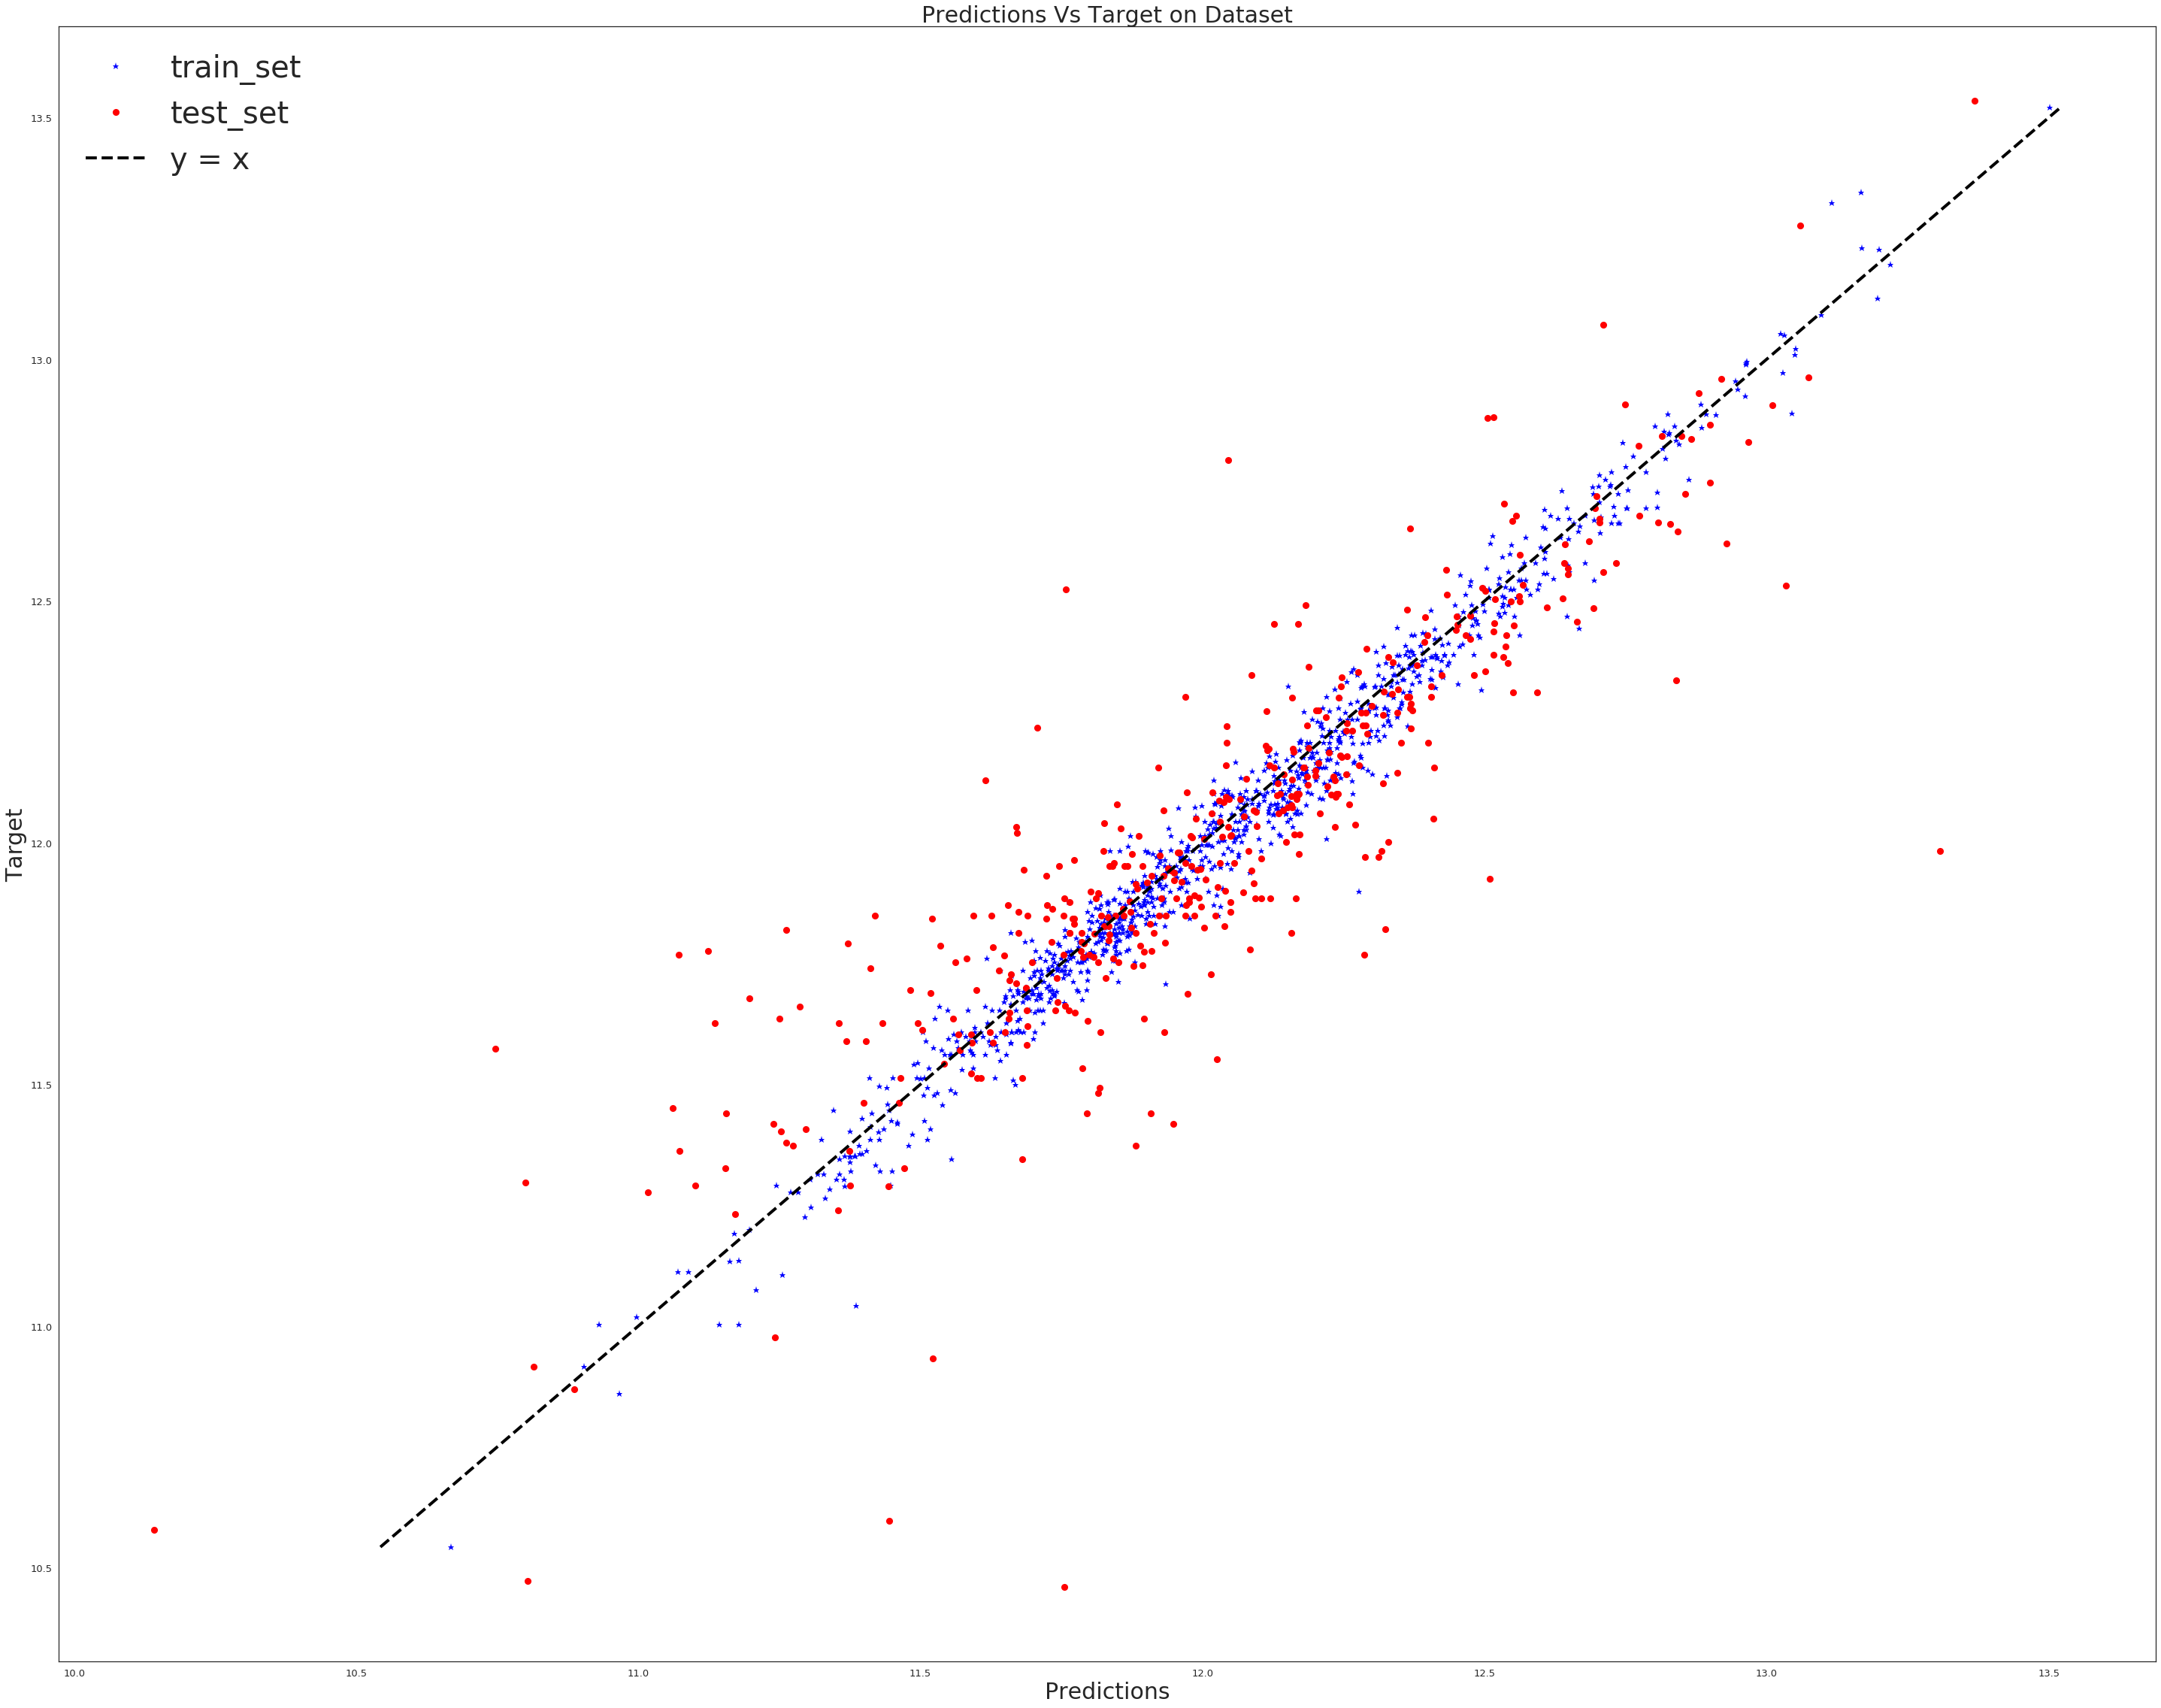

In [40]:
plt.figure(figsize=(50, 40))

plt.plot(predictions_train, target1, 'b*',label='train_set')
plt.plot(predictions_test, target2, 'ro',label='test_set')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Target', fontsize = 30)
plt.title('Predictions Vs Target on Dataset', fontsize = 30)
plt.plot([target1.min(), target1.max()], [target1.min(), target1.max()], 'k--', lw=4,label='y = x')
plt.legend(prop={'size': 40})
plt.show()

In [41]:
# Final Model
# Model decision
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[50],
                                         optimizer = tf.train.ProximalAdagradOptimizer(learning_rate=0.1,l2_regularization_strength=0.0005),
                                         dropout=False)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f38f9be9358>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpoavkirvj'}


In [42]:
regressor.fit(input_fn=lambda: input_fn(train), steps=120000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpoavkirvj/model.ckpt.
INFO:tensorflow:loss = 135.36928, step = 1
INFO:tensorflow:global_step/sec: 417.922
INFO:tensorflow:loss = 0.32632113, step = 101 (0.240 sec)
INFO:tensorflow:global_step/sec: 538.75
INFO:tensorflow:loss = 0.21152666, step = 201 (0.185 sec)
INFO:tensorflow:global_step/sec: 533.984
INFO:tensorflow:loss = 0.15906867, step = 301 (0.188 sec)
INFO:tensorflow:global_step/sec: 560.372
INFO:tensorflow:loss = 0.12690967, step = 401 (0.178 sec)
INFO:tensorflow:global_step/sec: 537.872
INFO:tensorflow:loss = 0.1083098, step = 501 (0.186 sec)
INFO:tensorflow:global_step/sec: 523.138
INFO:tensorflow:loss = 0.09369672, step = 601 (0.193 sec)
INFO:tensorflow:global_step/sec: 522.034
INFO:tensorflow:loss = 0.08489673, step = 701 (0.190 sec)
INFO:tensorflow:global_step

INFO:tensorflow:loss = 0.029427385, step = 3701 (0.205 sec)
INFO:tensorflow:global_step/sec: 522.336
INFO:tensorflow:loss = 0.028719177, step = 3801 (0.191 sec)
INFO:tensorflow:global_step/sec: 510.585
INFO:tensorflow:loss = 0.028728822, step = 3901 (0.196 sec)
INFO:tensorflow:global_step/sec: 526.465
INFO:tensorflow:loss = 0.028861934, step = 4001 (0.190 sec)
INFO:tensorflow:global_step/sec: 515.729
INFO:tensorflow:loss = 0.027652884, step = 4101 (0.194 sec)
INFO:tensorflow:global_step/sec: 527.118
INFO:tensorflow:loss = 0.028129233, step = 4201 (0.190 sec)
INFO:tensorflow:global_step/sec: 531.571
INFO:tensorflow:loss = 0.027894966, step = 4301 (0.188 sec)
INFO:tensorflow:global_step/sec: 521.858
INFO:tensorflow:loss = 0.026908621, step = 4401 (0.192 sec)
INFO:tensorflow:global_step/sec: 543.49
INFO:tensorflow:loss = 0.027619971, step = 4501 (0.185 sec)
INFO:tensorflow:global_step/sec: 533.316
INFO:tensorflow:loss = 0.026645938, step = 4601 (0.186 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 513.916
INFO:tensorflow:loss = 0.013418681, step = 11901 (0.195 sec)
INFO:tensorflow:global_step/sec: 538.111
INFO:tensorflow:loss = 0.013689499, step = 12001 (0.186 sec)
INFO:tensorflow:global_step/sec: 541.486
INFO:tensorflow:loss = 0.013751743, step = 12101 (0.185 sec)
INFO:tensorflow:global_step/sec: 531.013
INFO:tensorflow:loss = 0.013637679, step = 12201 (0.189 sec)
INFO:tensorflow:global_step/sec: 544.724
INFO:tensorflow:loss = 0.013837358, step = 12301 (0.183 sec)
INFO:tensorflow:global_step/sec: 530.322
INFO:tensorflow:loss = 0.013701853, step = 12401 (0.189 sec)
INFO:tensorflow:global_step/sec: 542.175
INFO:tensorflow:loss = 0.014058203, step = 12501 (0.184 sec)
INFO:tensorflow:global_step/sec: 517.398
INFO:tensorflow:loss = 0.0135269165, step = 12601 (0.194 sec)
INFO:tensorflow:global_step/sec: 519.796
INFO:tensorflow:loss = 0.012835023, step = 12701 (0.192 sec)
INFO:tensorflow:global_step/sec: 530.982
INFO:tensorflow:loss = 0.012984632, step

INFO:tensorflow:global_step/sec: 524.958
INFO:tensorflow:loss = 0.00962612, step = 20001 (0.189 sec)
INFO:tensorflow:global_step/sec: 517.444
INFO:tensorflow:loss = 0.009537267, step = 20101 (0.194 sec)
INFO:tensorflow:global_step/sec: 488.184
INFO:tensorflow:loss = 0.009975343, step = 20201 (0.205 sec)
INFO:tensorflow:global_step/sec: 519.534
INFO:tensorflow:loss = 0.010411889, step = 20301 (0.192 sec)
INFO:tensorflow:global_step/sec: 538.451
INFO:tensorflow:loss = 0.009606161, step = 20401 (0.191 sec)
INFO:tensorflow:global_step/sec: 517.316
INFO:tensorflow:loss = 0.009128238, step = 20501 (0.188 sec)
INFO:tensorflow:global_step/sec: 505.203
INFO:tensorflow:loss = 0.00997877, step = 20601 (0.197 sec)
INFO:tensorflow:global_step/sec: 512.266
INFO:tensorflow:loss = 0.010175592, step = 20701 (0.195 sec)
INFO:tensorflow:global_step/sec: 512.278
INFO:tensorflow:loss = 0.009578772, step = 20801 (0.195 sec)
INFO:tensorflow:global_step/sec: 513.904
INFO:tensorflow:loss = 0.009310315, step = 

INFO:tensorflow:global_step/sec: 520.252
INFO:tensorflow:loss = 0.008377595, step = 28101 (0.193 sec)
INFO:tensorflow:global_step/sec: 503.553
INFO:tensorflow:loss = 0.008500474, step = 28201 (0.198 sec)
INFO:tensorflow:global_step/sec: 523.887
INFO:tensorflow:loss = 0.007798407, step = 28301 (0.190 sec)
INFO:tensorflow:global_step/sec: 520.335
INFO:tensorflow:loss = 0.007616778, step = 28401 (0.192 sec)
INFO:tensorflow:global_step/sec: 546.567
INFO:tensorflow:loss = 0.007914795, step = 28501 (0.183 sec)
INFO:tensorflow:global_step/sec: 529.782
INFO:tensorflow:loss = 0.00799981, step = 28601 (0.189 sec)
INFO:tensorflow:global_step/sec: 533.523
INFO:tensorflow:loss = 0.008581285, step = 28701 (0.187 sec)
INFO:tensorflow:global_step/sec: 518.339
INFO:tensorflow:loss = 0.007983246, step = 28801 (0.193 sec)
INFO:tensorflow:global_step/sec: 523.402
INFO:tensorflow:loss = 0.007402487, step = 28901 (0.191 sec)
INFO:tensorflow:global_step/sec: 525.91
INFO:tensorflow:loss = 0.007946536, step = 

INFO:tensorflow:loss = 0.0066961176, step = 36101 (0.188 sec)
INFO:tensorflow:global_step/sec: 525.651
INFO:tensorflow:loss = 0.007678454, step = 36201 (0.190 sec)
INFO:tensorflow:global_step/sec: 535.731
INFO:tensorflow:loss = 0.0068365484, step = 36301 (0.187 sec)
INFO:tensorflow:global_step/sec: 531.292
INFO:tensorflow:loss = 0.006497474, step = 36401 (0.190 sec)
INFO:tensorflow:global_step/sec: 521.81
INFO:tensorflow:loss = 0.007322715, step = 36501 (0.190 sec)
INFO:tensorflow:global_step/sec: 509.61
INFO:tensorflow:loss = 0.007241338, step = 36601 (0.196 sec)
INFO:tensorflow:global_step/sec: 507.832
INFO:tensorflow:loss = 0.006498363, step = 36701 (0.197 sec)
INFO:tensorflow:global_step/sec: 533.493
INFO:tensorflow:loss = 0.0067470297, step = 36801 (0.187 sec)
INFO:tensorflow:global_step/sec: 508.424
INFO:tensorflow:loss = 0.007578346, step = 36901 (0.199 sec)
INFO:tensorflow:global_step/sec: 512.803
INFO:tensorflow:loss = 0.0067220884, step = 37001 (0.193 sec)
INFO:tensorflow:glo

INFO:tensorflow:loss = 0.0060238177, step = 44101 (0.194 sec)
INFO:tensorflow:global_step/sec: 523.234
INFO:tensorflow:loss = 0.0057964525, step = 44201 (0.187 sec)
INFO:tensorflow:global_step/sec: 541.52
INFO:tensorflow:loss = 0.005676659, step = 44301 (0.185 sec)
INFO:tensorflow:global_step/sec: 515.318
INFO:tensorflow:loss = 0.005858747, step = 44401 (0.194 sec)
INFO:tensorflow:global_step/sec: 535.991
INFO:tensorflow:loss = 0.006069126, step = 44501 (0.186 sec)
INFO:tensorflow:global_step/sec: 515.72
INFO:tensorflow:loss = 0.006412999, step = 44601 (0.194 sec)
INFO:tensorflow:global_step/sec: 533.559
INFO:tensorflow:loss = 0.005644868, step = 44701 (0.188 sec)
INFO:tensorflow:global_step/sec: 530.459
INFO:tensorflow:loss = 0.0056478297, step = 44801 (0.190 sec)
INFO:tensorflow:global_step/sec: 536.783
INFO:tensorflow:loss = 0.0060371393, step = 44901 (0.185 sec)
INFO:tensorflow:global_step/sec: 502.582
INFO:tensorflow:loss = 0.0062332465, step = 45001 (0.198 sec)
INFO:tensorflow:gl

INFO:tensorflow:loss = 0.0055762376, step = 52101 (0.201 sec)
INFO:tensorflow:global_step/sec: 523.471
INFO:tensorflow:loss = 0.005145281, step = 52201 (0.191 sec)
INFO:tensorflow:global_step/sec: 511.938
INFO:tensorflow:loss = 0.0052631656, step = 52301 (0.197 sec)
INFO:tensorflow:global_step/sec: 480.866
INFO:tensorflow:loss = 0.0058164885, step = 52401 (0.206 sec)
INFO:tensorflow:global_step/sec: 543.349
INFO:tensorflow:loss = 0.005700499, step = 52501 (0.184 sec)
INFO:tensorflow:global_step/sec: 560.566
INFO:tensorflow:loss = 0.005183369, step = 52601 (0.179 sec)
INFO:tensorflow:global_step/sec: 537.904
INFO:tensorflow:loss = 0.005157696, step = 52701 (0.185 sec)
INFO:tensorflow:global_step/sec: 516.346
INFO:tensorflow:loss = 0.005505101, step = 52801 (0.194 sec)
INFO:tensorflow:global_step/sec: 498.361
INFO:tensorflow:loss = 0.0057710293, step = 52901 (0.201 sec)
INFO:tensorflow:global_step/sec: 534.562
INFO:tensorflow:loss = 0.0055588195, step = 53001 (0.189 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 0.0053792945, step = 60101 (0.196 sec)
INFO:tensorflow:global_step/sec: 529.766
INFO:tensorflow:loss = 0.00461779, step = 60201 (0.190 sec)
INFO:tensorflow:global_step/sec: 515.014
INFO:tensorflow:loss = 0.005242809, step = 60301 (0.192 sec)
INFO:tensorflow:global_step/sec: 520.911
INFO:tensorflow:loss = 0.005100871, step = 60401 (0.192 sec)
INFO:tensorflow:global_step/sec: 534.461
INFO:tensorflow:loss = 0.0046832007, step = 60501 (0.187 sec)
INFO:tensorflow:global_step/sec: 512.499
INFO:tensorflow:loss = 0.0053787995, step = 60601 (0.195 sec)
INFO:tensorflow:global_step/sec: 510.305
INFO:tensorflow:loss = 0.004970412, step = 60701 (0.196 sec)
INFO:tensorflow:global_step/sec: 511.055
INFO:tensorflow:loss = 0.004762583, step = 60801 (0.196 sec)
INFO:tensorflow:global_step/sec: 514.262
INFO:tensorflow:loss = 0.005449469, step = 60901 (0.194 sec)
INFO:tensorflow:global_step/sec: 515.768
INFO:tensorflow:loss = 0.005103535, step = 61001 (0.194 sec)
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 511.982
INFO:tensorflow:loss = 0.004973288, step = 68201 (0.196 sec)
INFO:tensorflow:global_step/sec: 527.267
INFO:tensorflow:loss = 0.0048877485, step = 68301 (0.190 sec)
INFO:tensorflow:global_step/sec: 476.341
INFO:tensorflow:loss = 0.0048270402, step = 68401 (0.208 sec)
INFO:tensorflow:global_step/sec: 528.883
INFO:tensorflow:loss = 0.004698062, step = 68501 (0.189 sec)
INFO:tensorflow:global_step/sec: 528.899
INFO:tensorflow:loss = 0.004479906, step = 68601 (0.189 sec)
INFO:tensorflow:global_step/sec: 525.58
INFO:tensorflow:loss = 0.004535082, step = 68701 (0.191 sec)
INFO:tensorflow:global_step/sec: 512.561
INFO:tensorflow:loss = 0.004717746, step = 68801 (0.194 sec)
INFO:tensorflow:global_step/sec: 496.683
INFO:tensorflow:loss = 0.004944179, step = 68901 (0.202 sec)
INFO:tensorflow:global_step/sec: 527.263
INFO:tensorflow:loss = 0.005014573, step = 69001 (0.189 sec)
INFO:tensorflow:global_step/sec: 498.685
INFO:tensorflow:loss = 0.0046885214, ste

INFO:tensorflow:loss = 0.0042635254, step = 76201 (0.198 sec)
INFO:tensorflow:global_step/sec: 503.423
INFO:tensorflow:loss = 0.004483667, step = 76301 (0.199 sec)
INFO:tensorflow:global_step/sec: 512.809
INFO:tensorflow:loss = 0.004759334, step = 76401 (0.196 sec)
INFO:tensorflow:global_step/sec: 502.774
INFO:tensorflow:loss = 0.0046530482, step = 76501 (0.198 sec)
INFO:tensorflow:global_step/sec: 519.984
INFO:tensorflow:loss = 0.004451233, step = 76601 (0.194 sec)
INFO:tensorflow:global_step/sec: 510.57
INFO:tensorflow:loss = 0.004314594, step = 76701 (0.194 sec)
INFO:tensorflow:global_step/sec: 509.824
INFO:tensorflow:loss = 0.004190684, step = 76801 (0.197 sec)
INFO:tensorflow:global_step/sec: 521.16
INFO:tensorflow:loss = 0.0042943843, step = 76901 (0.192 sec)
INFO:tensorflow:global_step/sec: 522.777
INFO:tensorflow:loss = 0.004631296, step = 77001 (0.190 sec)
INFO:tensorflow:global_step/sec: 513.44
INFO:tensorflow:loss = 0.0046881903, step = 77101 (0.194 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 500.519
INFO:tensorflow:loss = 0.004413461, step = 84301 (0.198 sec)
INFO:tensorflow:global_step/sec: 535.208
INFO:tensorflow:loss = 0.0040969467, step = 84401 (0.187 sec)
INFO:tensorflow:global_step/sec: 535.256
INFO:tensorflow:loss = 0.0040900493, step = 84501 (0.187 sec)
INFO:tensorflow:global_step/sec: 538.332
INFO:tensorflow:loss = 0.0041286196, step = 84601 (0.185 sec)
INFO:tensorflow:global_step/sec: 556.814
INFO:tensorflow:loss = 0.0046542943, step = 84701 (0.180 sec)
INFO:tensorflow:global_step/sec: 511.012
INFO:tensorflow:loss = 0.004448063, step = 84801 (0.196 sec)
INFO:tensorflow:global_step/sec: 517.917
INFO:tensorflow:loss = 0.0040492956, step = 84901 (0.194 sec)
INFO:tensorflow:global_step/sec: 507.507
INFO:tensorflow:loss = 0.0041064424, step = 85001 (0.197 sec)
INFO:tensorflow:global_step/sec: 514.285
INFO:tensorflow:loss = 0.004552224, step = 85101 (0.194 sec)
INFO:tensorflow:global_step/sec: 512.342
INFO:tensorflow:loss = 0.0045649037

INFO:tensorflow:global_step/sec: 530.339
INFO:tensorflow:loss = 0.0044212267, step = 92301 (0.189 sec)
INFO:tensorflow:global_step/sec: 518.77
INFO:tensorflow:loss = 0.0040636044, step = 92401 (0.194 sec)
INFO:tensorflow:global_step/sec: 524.052
INFO:tensorflow:loss = 0.0038789276, step = 92501 (0.189 sec)
INFO:tensorflow:global_step/sec: 513.934
INFO:tensorflow:loss = 0.003987471, step = 92601 (0.195 sec)
INFO:tensorflow:global_step/sec: 508.067
INFO:tensorflow:loss = 0.0040684897, step = 92701 (0.196 sec)
INFO:tensorflow:global_step/sec: 493.407
INFO:tensorflow:loss = 0.004371337, step = 92801 (0.204 sec)
INFO:tensorflow:global_step/sec: 547.496
INFO:tensorflow:loss = 0.004428955, step = 92901 (0.181 sec)
INFO:tensorflow:global_step/sec: 518.816
INFO:tensorflow:loss = 0.0040393514, step = 93001 (0.193 sec)
INFO:tensorflow:global_step/sec: 495.952
INFO:tensorflow:loss = 0.0038822608, step = 93101 (0.201 sec)
INFO:tensorflow:global_step/sec: 526.56
INFO:tensorflow:loss = 0.0039712437, 

INFO:tensorflow:global_step/sec: 520.534
INFO:tensorflow:loss = 0.0041398033, step = 100301 (0.193 sec)
INFO:tensorflow:global_step/sec: 506.611
INFO:tensorflow:loss = 0.0037973581, step = 100401 (0.197 sec)
INFO:tensorflow:global_step/sec: 537.277
INFO:tensorflow:loss = 0.0037814525, step = 100501 (0.186 sec)
INFO:tensorflow:global_step/sec: 531.895
INFO:tensorflow:loss = 0.004277002, step = 100601 (0.188 sec)
INFO:tensorflow:global_step/sec: 532.057
INFO:tensorflow:loss = 0.004332709, step = 100701 (0.188 sec)
INFO:tensorflow:global_step/sec: 522.841
INFO:tensorflow:loss = 0.0038391214, step = 100801 (0.191 sec)
INFO:tensorflow:global_step/sec: 513.207
INFO:tensorflow:loss = 0.0037641802, step = 100901 (0.197 sec)
INFO:tensorflow:global_step/sec: 517.03
INFO:tensorflow:loss = 0.0039636786, step = 101001 (0.193 sec)
INFO:tensorflow:global_step/sec: 511.638
INFO:tensorflow:loss = 0.004386416, step = 101101 (0.196 sec)
INFO:tensorflow:global_step/sec: 505.152
INFO:tensorflow:loss = 0.00

INFO:tensorflow:loss = 0.0041307183, step = 108201 (0.184 sec)
INFO:tensorflow:global_step/sec: 536.253
INFO:tensorflow:loss = 0.0042526005, step = 108301 (0.187 sec)
INFO:tensorflow:global_step/sec: 534.472
INFO:tensorflow:loss = 0.0040778667, step = 108401 (0.189 sec)
INFO:tensorflow:global_step/sec: 518.82
INFO:tensorflow:loss = 0.0037513494, step = 108501 (0.191 sec)
INFO:tensorflow:global_step/sec: 554.23
INFO:tensorflow:loss = 0.0036566118, step = 108601 (0.181 sec)
INFO:tensorflow:global_step/sec: 510.601
INFO:tensorflow:loss = 0.0037290102, step = 108701 (0.196 sec)
INFO:tensorflow:global_step/sec: 528.917
INFO:tensorflow:loss = 0.0039344286, step = 108801 (0.188 sec)
INFO:tensorflow:global_step/sec: 505.795
INFO:tensorflow:loss = 0.0042228955, step = 108901 (0.198 sec)
INFO:tensorflow:global_step/sec: 535.572
INFO:tensorflow:loss = 0.004159068, step = 109001 (0.187 sec)
INFO:tensorflow:global_step/sec: 502.945
INFO:tensorflow:loss = 0.0038553714, step = 109101 (0.199 sec)
INFO

INFO:tensorflow:global_step/sec: 497.827
INFO:tensorflow:loss = 0.003872074, step = 116201 (0.201 sec)
INFO:tensorflow:global_step/sec: 502.136
INFO:tensorflow:loss = 0.0041014035, step = 116301 (0.199 sec)
INFO:tensorflow:global_step/sec: 498.278
INFO:tensorflow:loss = 0.003905654, step = 116401 (0.201 sec)
INFO:tensorflow:global_step/sec: 510.482
INFO:tensorflow:loss = 0.0035824445, step = 116501 (0.196 sec)
INFO:tensorflow:global_step/sec: 493.932
INFO:tensorflow:loss = 0.0039027527, step = 116601 (0.202 sec)
INFO:tensorflow:global_step/sec: 517.608
INFO:tensorflow:loss = 0.0041675842, step = 116701 (0.193 sec)
INFO:tensorflow:global_step/sec: 515.12
INFO:tensorflow:loss = 0.0037627746, step = 116801 (0.194 sec)
INFO:tensorflow:global_step/sec: 515.851
INFO:tensorflow:loss = 0.003532889, step = 116901 (0.194 sec)
INFO:tensorflow:global_step/sec: 532.839
INFO:tensorflow:loss = 0.004072332, step = 117001 (0.188 sec)
INFO:tensorflow:global_step/sec: 520.138
INFO:tensorflow:loss = 0.004

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f38f9be90b8>, 'hidden_units': [50], 'feature_columns': (_RealValuedColumn(column_name='2ndFlrSF', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='3SsnPorch', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Alley', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BedroomAbvGr', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtExposure', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtFinSF1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtFinSF2', di

In [43]:
test.rename({'Exterior1st_Wd Sdng':'Exterior1st_Wd_Sdng'}, axis='columns',inplace=True)
test.rename({'Exterior2nd_Brk Cmn':'Exterior2nd_Brk_Cmn'}, axis='columns',inplace=True)
test.rename({'Exterior2nd_Wd Sdng':'Exterior2nd_Wd_Sdng'}, axis='columns',inplace=True)
test.rename({'Exterior2nd_Wd Shng':'Exterior2nd_Wd_Shng'}, axis='columns',inplace=True)
test.rename({'MSZoning_C (all)':'MSZoning_C_all'}, axis='columns',inplace=True)
test.rename({'HouseStyle_1.5Fin':'HouseStyle_1_5Fin'}, axis='columns',inplace=True)
test.rename({'HouseStyle_1.5Unf':'HouseStyle_1_5Unf'}, axis='columns',inplace=True)
test.rename({'HouseStyle_2.5Fin':'HouseStyle_2_5Fin'}, axis='columns',inplace=True)
test.rename({'HouseStyle_2.5Unf':'HouseStyle_2_5Unf'}, axis='columns',inplace=True)
test.rename({'RoofMatl_Tar&Grv':'RoofMatl_Tar_Grv'}, axis='columns',inplace=True)

In [44]:
# Tensorflow Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
tf_preds = np.expm1(list(itertools.islice(y_predict, test.shape[0])))
tf_preds[0:10]

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpoavkirvj/model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([155930.4 , 148121.11, 196854.94, 204321.34, 187015.17, 173242.81,
       189712.22, 164681.1 , 179846.4 , 136389.9 ], dtype=float32)

* Every time I run it, the tensorflow part gives different results. I kept the best training!

## Weighted Average Model

In [45]:
preds = 0.15*lasso_preds  + 0.15*ridge_preds + 0.2*xgb_preds + 0.2*GBoost_preds +0.15*LGB_preds  + 0.15*tf_preds

In [46]:
preds[0:10]

array([126527.47231212, 156424.2568132 , 185254.83950679, 194725.857699  ,
       193263.55019598, 173208.05747545, 177465.88635276, 165092.11276407,
       182133.74850004, 126097.73922624])

In [51]:
ID = list(range(1461,1461+len(preds)))

results = pd.DataFrame()
results['Id'] = ID
results.Id = results.Id.astype(int)
results['SalePrice'] = preds

results.to_csv('output.csv',index=False)    #--> 0.11467

**Final_Score: 0.11467**